# Solving PDEs with PyTorch

This file contains our first approach to solve PDEs with neural networks on the PyTorch Library.  
We will try to solve the poisson Equation :  
$-\Delta u(x) = f(x)$ on $\Omega = [0,1]^2$  
With Dirichlet homogeneous boundary conditions $u|_{\partial \Omega}=0$ and $f(x_1, x_2)=2\pi^2 sin(\pi x_1) sin(\pi x_2)$

The loss to minimize here is $\mathcal{L} = ||\Delta u(x) + f(x)||_2$, the MSE of the PDE  
The true function $u$ should be $u(x_1, x_2)=sin(\pi x_1) sin(\pi x_2)$

## Import Libraries and define constants

In [1]:
__file__ = 'C:/Users/antie/Documents/Pole_recherche/Tsunami'

In [19]:
__file__ = 'C:/Users/Gilles/CS/cours/PoleProjet/FormationRecherche/Tsunami/TP/sceance4/Tsunami'

In [2]:
import os

print(os.getcwd())
os.chdir(__file__)
print(os.getcwd())

c:\Users\antie\Documents\Pole_recherche\Tsunami\differentiate
C:\Users\antie\Documents\Pole_recherche\Tsunami


In [3]:
import torch
import torch.nn as nn
import numpy as np
device = torch.device("cuda:0") # Specify GPU Usage for computations

In [11]:
N = 2 # Input size, corresponds to antecedent space dimension
learning_rate = 0.05 # Parameter for Adam optimizer
training_steps = 200 # Epoch computed
report_steps = training_steps//20 # How often is the loss printed during training
grid_length = 20 # Length of the square grid considered for training

## Define neural network structure

Here we consider a perceptron with 2 hidden layers of 10 nodes, with N inputs and 1 output

In [5]:
multilayer_perceptron = nn.Sequential(
    nn.Linear(N, 10),
    nn.ELU(),
    nn.Linear(10, 10),
    nn.ELU(),
    nn.Linear(10, 1)
)

print(multilayer_perceptron)

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): ELU(alpha=1.0)
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): ELU(alpha=1.0)
  (4): Linear(in_features=10, out_features=1, bias=True)
)


In [6]:
# Universal Approximator, using the paper from 1997
def g(x):
  N_x = multilayer_perceptron(x)
  A = 0
  F = 1
  return N_x*F + A

# Given EDO
def f(x):
  return 2*np.pi**2*np.sin(np.pi*x[:,0])*np.sin(np.pi*x[:,1])

# Loss function
loss_fct = nn.MSELoss()     
optimizer = torch.optim.Adam(multilayer_perceptron.parameters())

In [7]:
# Code taken from https://discuss.pytorch.org/t/how-to-calculate-laplacian-for-multiple-batches-in-parallel/104888
# Computes the laplacian for a batch, to use in the loss calculation

def laplace(model, x: torch.tensor):
    """
    Laplacian (= sum of 2nd derivations)
     of (evaluated) nd->1d-function fx w.r.t. nd-tensor x
    :rtype: torch.Tensor
    """
    laplacian = torch.zeros(x.shape[0]) #array to store values of laplacian

    for i, xi in enumerate(x):
        hess = torch.autograd.functional.hessian(model, xi.unsqueeze(0), create_graph=True)
        laplacian[i] = torch.diagonal(hess.view(N, N), offset=0).sum()
    
    return laplacian

## Define the grid on which to train the neural network  
We sample $\Omega = [0,1]^2$ with grid_length² uniformely distributed points

In [12]:
X = np.linspace(0, 1, grid_length)
Y = np.linspace(0, 1, grid_length)

# Put the training points and values in tensors
Z = np.array([[x,y] for x in X for y in Y])
Z_values = torch.FloatTensor(f(Z)).unsqueeze(1) # Values in tensor, unsqueeze allows to go from [10000] to [10000, 1]
Z_training = torch.FloatTensor(Z) # Points in tensor
print(Z_training.size())

torch.Size([400, 2])


## Train the neural network

In [13]:
multilayer_perceptron.train(True)

for epoch in range(training_steps):
    optimizer.zero_grad()   # On réinitialise les gradients entre chaque epoch

    Z_out = multilayer_perceptron(Z_training)   # Output du réseau de neurones
    loss = loss_fct(-1*laplace(multilayer_perceptron, Z_training).unsqueeze(1), Z_values)    # On calcule la loss nécéssaire
    loss.backward()

    optimizer.step()
    
    if epoch%report_steps==report_steps-1:
        print("Epoch n°{}: ".format(epoch+1), loss.item())
    
multilayer_perceptron.train(False)

Epoch n°10:  85.05429077148438
Epoch n°20:  84.28195190429688
Epoch n°30:  83.36837768554688
Epoch n°40:  82.274169921875
Epoch n°50:  80.96105194091797
Epoch n°60:  79.32676696777344
Epoch n°70:  77.45133972167969
Epoch n°80:  75.17887878417969
Epoch n°90:  72.50028991699219
Epoch n°100:  69.51350402832031
Epoch n°110:  65.99634552001953
Epoch n°120:  62.21381759643555
Epoch n°130:  58.077762603759766
Epoch n°140:  54.00823211669922
Epoch n°150:  49.792171478271484
Epoch n°160:  45.80741882324219
Epoch n°170:  42.29844665527344
Epoch n°180:  39.458038330078125
Epoch n°190:  36.545936584472656
Epoch n°200:  34.30348587036133


Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): ELU(alpha=1.0)
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): ELU(alpha=1.0)
  (4): Linear(in_features=10, out_features=1, bias=True)
)

## Display results

In [14]:
import matplotlib.pyplot as plt

# Random sampling of points on which to display the approximated function
X_noise = X + (np.random.rand(grid_length)-0.5)/grid_length
Y_noise = Y + (np.random.rand(grid_length)-0.5)/grid_length
Z_validation = multilayer_perceptron(torch.FloatTensor(np.array([[x,y] for x in X for y in Y])))

(0.0, 20.0, 0.0, 20.0)

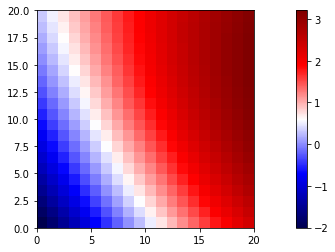

In [15]:
plt.pcolormesh(torch.reshape(Z_validation, (grid_length, grid_length)).detach().numpy(), cmap="seismic")
plt.colorbar()
plt.axis("square")

(0.0, 20.0, 0.0, 20.0)

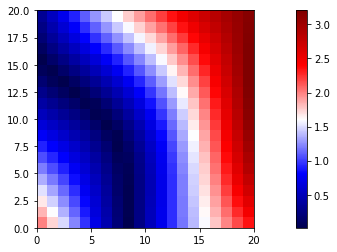

In [16]:
"""
Error with respect to true function
"""
error = torch.abs(Z_validation - Z_values/(2*np.pi**2))
plt.pcolormesh(torch.reshape(error, (grid_length, grid_length)).detach().numpy(), cmap="seismic")
plt.colorbar()
plt.axis("square")